In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

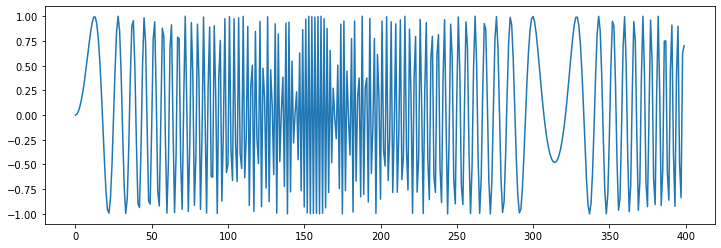

In [12]:
# make the original data
series = np.sin((0.1*np.arange(400))**2)
plt.figure(figsize=(12,4))
plt.plot(series)
plt.show()

In [9]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

This is a time series of the form:

$$x(t) = sine(wt^2)$$

In [17]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1,T)
Y = np.array(Y).reshape(-1,1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10) Y.shape (390, 1)


In [19]:
### try autoregressive linear model
model = nn.Linear(T, 1)

In [20]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

In [21]:
# Make inputs and targets
x_train = torch.from_numpy(X[:N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:N//2].astype(np.float32))
x_test = torch.from_numpy(X[N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[N//2:].astype(np.float32))

In [22]:
# Training
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs = 200):
    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Save loss
        train_losses[it] = loss.item()
        
        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        if (it + 1) % 5 ==0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    
    return train_losses, test_losses

In [23]:
train_losses, test_losses = full_gd(model, criterion, optimizer, x_train, y_train, x_test, y_test)

Epoch 5/200, Train Loss: 0.5278, Test Loss: 0.6794
Epoch 10/200, Train Loss: 0.5006, Test Loss: 0.5578
Epoch 15/200, Train Loss: 0.4946, Test Loss: 0.6240
Epoch 20/200, Train Loss: 0.4881, Test Loss: 0.6146
Epoch 25/200, Train Loss: 0.4891, Test Loss: 0.5719
Epoch 30/200, Train Loss: 0.4839, Test Loss: 0.5929
Epoch 35/200, Train Loss: 0.4859, Test Loss: 0.6059
Epoch 40/200, Train Loss: 0.4838, Test Loss: 0.5823
Epoch 45/200, Train Loss: 0.4839, Test Loss: 0.5883
Epoch 50/200, Train Loss: 0.4836, Test Loss: 0.5951
Epoch 55/200, Train Loss: 0.4834, Test Loss: 0.5881
Epoch 60/200, Train Loss: 0.4835, Test Loss: 0.5887
Epoch 65/200, Train Loss: 0.4834, Test Loss: 0.5909
Epoch 70/200, Train Loss: 0.4833, Test Loss: 0.5901
Epoch 75/200, Train Loss: 0.4834, Test Loss: 0.5885
Epoch 80/200, Train Loss: 0.4833, Test Loss: 0.5907
Epoch 85/200, Train Loss: 0.4833, Test Loss: 0.5895
Epoch 90/200, Train Loss: 0.4833, Test Loss: 0.5893
Epoch 95/200, Train Loss: 0.4833, Test Loss: 0.5903
Epoch 100/200

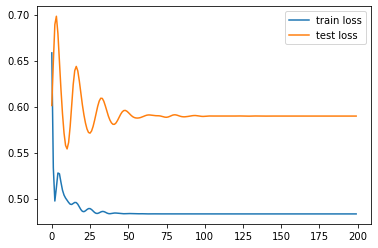

In [24]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [27]:
# One-step forecast using true targets
# Note: even the one-step forecast fails badly

validation_target = Y[N//2:]

with torch.no_grad():
    validation_predictions = model(x_test).numpy()
# validation_predictions = []

# index of first validation input
# i = 0

# while len(validation_predictions) < len(validation_target):
#     input_ = x_test[i].view(1,-1)  # 10개씩 tensor가 input 됨
#     p = model(input_)[0,0].item()  # 1 x 1 array -> scalar  (첫번째 tensor를 선택) --> 10개의 N에 대하여 1개 prediction
#     i += 1
    
#     # update the predictions list
#     validation_predictions.append(p)
#     #print(validation_predictions)

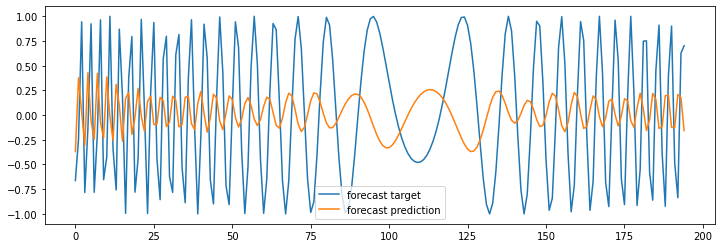

In [31]:
plt.figure(figsize=(12,4))
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label ='forecast prediction')
plt.legend()
plt.show()

In [32]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = torch.from_numpy(X[N//2:].astype(np.float32))[0]
print(last_x)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.view(1, -1)
    p = model(input_)
    # [0,0] # 1 x 1 array -> scalar
    
    # update the predictions list
    validation_predictions.append(p[0,0].item())     # 여기까지는 도입 부분을 전과 바꾼 것이지 실지로는 똑같다.
    
    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))      # seq 함수와 같은 역할을 한다. 한칸 이동한 x 값에 p : prediction 값을 추가함
    #print(last_x)                               # last_x 는 계속 한칸씩 이동하며 10개 tensor를 유지한다.

tensor([-0.1170,  0.7744, -0.9947,  0.6124,  0.1685, -0.8509,  0.9507, -0.3589,
        -0.5153,  0.9949])


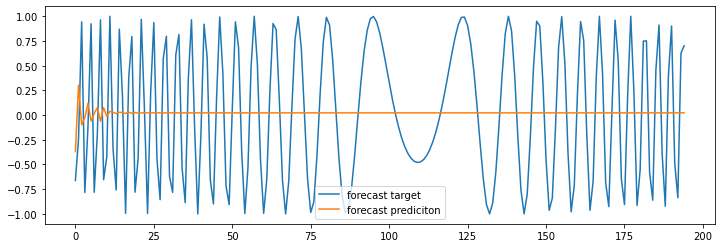

In [34]:
plt.figure(figsize=(12,4))
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast prediciton')
plt.legend()
plt.show()